In [1]:
import glob
import os
import pathlib

import numpy as np
import pandas as pd

from util.image import unnormalize

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import functional as F

from torchvision import transforms
from torchinfo import torchinfo
from tqdm import tqdm
import matplotlib.pyplot as plt

import albumentations as A
import torch.nn.functional as F

from PIL import Image

import torchmetrics
from torchvision.utils import save_image, make_grid
import cv2
from util.io import load_ckpt

from util.loss import  InpaintingLoss
import os, glob

import efficientunet
import random

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device("cpu")

In [2]:
dataset_path = 'Datasets/inpainting/img_align_celeba/'

In [3]:
files = glob.glob(dataset_path+'*.jpg')

In [4]:
sizes = (64, 64)

rescale_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(sizes, antialias= False)
])

In [5]:
img = np.array(Image.open(dataset_path+'000041.jpg'))

In [6]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(img, 1.1, 2)

# loop over all the detected faces
for (x,y,w,h) in faces:
   face = img[y:y + h, x:x + w]

# Display an image in a window


In [7]:
face.shape

(133, 133, 3)

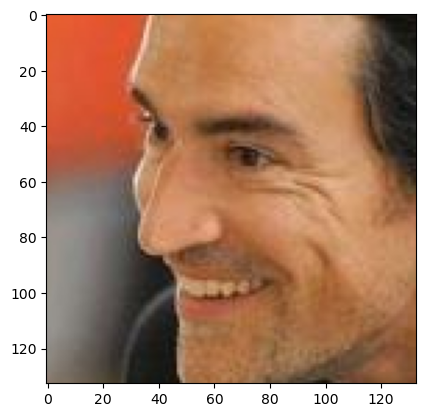

In [9]:
plt.imshow(face)

In [8]:
def get_face(img):
    faces = face_cascade.detectMultiScale(img, 1.1, 2)
    for (x,y,w,h) in faces:
        face = img[y:y + h, x:x + w]
    return face

In [11]:
# faces = []
# failures = 0
# bar = tqdm(files)
# for x in bar:
#             try:
#                 face = get_face(np.array(Image.open(x)))
#                 faces.append(rescale_transform(face))
#             except:
#                 failures+=1
#                 bar.set_description_str("Failures: {}".format(failures))

Failures: 3323:  48%|████▊     | 96676/202599 [33:18<36:29, 48.38it/s]  


KeyboardInterrupt: 

In [14]:
# faces_as_tensor = torch.stack(faces)

In [9]:
with open('faces.pth', 'rb') as f:
    faces_as_tensor = torch.load(f)

In [17]:
# torch.save(faces_as_tensor, 'faces.pth')



In [13]:
# import pickle as pkl

# with open('facefiles.pkl', 'wb') as f:
#     pkl.dump(faces, f)

In [56]:
class celebDataset(Dataset):
    def __init__(self, files):
        self.faces = files 


    def __len__(self):
        return len(self.faces)

    def __getitem__(self, idx):
        img = self.faces[idx]
        mask = np.ones(sizes)
        low_vertical = sizes[0]//5 + random.randint(-10, +10)
        high_vertical = 4*sizes[0]//5 + random.randint(-10, +10)
        mask[int(2*sizes[0]//3) + random.randint(-10, +10):, low_vertical: high_vertical] = 0

        masked = img*mask[None, ...]
        return img, masked

In [57]:
dataset = celebDataset(faces_as_tensor)

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.9, 0.1])

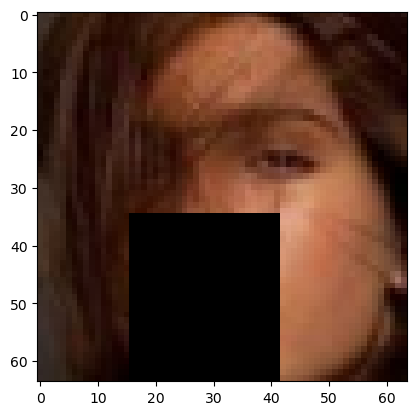

In [68]:
plt.imshow(train_dataset[0][1].permute(1,2,0))

In [83]:
BATCH_SIZE = 500

train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, BATCH_SIZE)

In [85]:
class EarlyStopping:

    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)

        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [88]:
EPOCHS = 10

model = efficientunet.get_efficientunet_b0(out_channels=3, concat_input=True, pretrained=True).to(device)
optim = torch.optim.Adam(model.parameters(), lr = 1e-4)
criterion = torch.nn.L1Loss()
early_stopping = EarlyStopping(patience=3, verbose=True, path = 'efficientunet_temp.pth')


for epoch_num in range(EPOCHS):
    train_loss = 0
    i = 0

    bar = tqdm(train_dataloader)
    for img, mask in bar:
        i+=1
        optim.zero_grad()

        img = img.to(device)
        mask = mask.to(device)
        predictions = F.sigmoid(model(img))

        batch_loss = criterion(predictions, img)

        batch_loss.backward()
        optim.step()

        train_loss+= batch_loss.item()
        bar.set_description_str("Training loss: {:.4f}".format(train_loss/i))

    train_loss/=i

    
    with torch.no_grad():
        val_loss = 0
        i = 0
        bar = tqdm(val_dataloader)
        for img, mask in bar:
            i+=1
            optim.zero_grad()

            img = img.to(device)
            mask = mask.to(device)
            predictions = F.sigmoid(model(img))

            batch_loss = criterion(predictions, img)

            val_loss+= batch_loss.item()
            bar.set_description_str("Validation loss: {:.4f}".format(val_loss/i))

        val_loss/=i


    print("Epoch [{}/{}], Train Loss: {:.4f}".format(epoch_num+1, EPOCHS, train_loss))
    print("Epoch [{}/{}], Val Loss: {:.4f}".format(epoch_num+1, EPOCHS, val_loss))
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        print('-'*60)
        break

Validation loss: 0.0696: 100%|██████████| 19/19 [00:02<00:00,  7.24it/s]


Epoch [1/10], Train Loss: 0.1112
Epoch [1/10], Val Loss: 0.0696
Validation loss decreased (inf --> 0.069610).  Saving model ...


Validation loss: 0.0418: 100%|██████████| 19/19 [00:02<00:00,  8.05it/s]


Epoch [2/10], Train Loss: 0.0541
Epoch [2/10], Val Loss: 0.0418
Validation loss decreased (0.069610 --> 0.041787).  Saving model ...


Validation loss: 0.0267: 100%|██████████| 19/19 [00:02<00:00,  8.01it/s]


Epoch [3/10], Train Loss: 0.0334
Epoch [3/10], Val Loss: 0.0267
Validation loss decreased (0.041787 --> 0.026743).  Saving model ...


Validation loss: 0.0195: 100%|██████████| 19/19 [00:02<00:00,  8.11it/s]


Epoch [4/10], Train Loss: 0.0227
Epoch [4/10], Val Loss: 0.0195
Validation loss decreased (0.026743 --> 0.019487).  Saving model ...


Validation loss: 0.0162: 100%|██████████| 19/19 [00:02<00:00,  8.15it/s]


Epoch [5/10], Train Loss: 0.0172
Epoch [5/10], Val Loss: 0.0162
Validation loss decreased (0.019487 --> 0.016243).  Saving model ...


Validation loss: 0.0140: 100%|██████████| 19/19 [00:02<00:00,  8.08it/s]


Epoch [6/10], Train Loss: 0.0145
Epoch [6/10], Val Loss: 0.0140
Validation loss decreased (0.016243 --> 0.013972).  Saving model ...


Validation loss: 0.0123: 100%|██████████| 19/19 [00:02<00:00,  8.00it/s]


Epoch [7/10], Train Loss: 0.0129
Epoch [7/10], Val Loss: 0.0123
Validation loss decreased (0.013972 --> 0.012333).  Saving model ...


Validation loss: 0.0115: 100%|██████████| 19/19 [00:02<00:00,  8.11it/s]


Epoch [8/10], Train Loss: 0.0119
Epoch [8/10], Val Loss: 0.0115
Validation loss decreased (0.012333 --> 0.011490).  Saving model ...


Validation loss: 0.0118: 100%|██████████| 19/19 [00:02<00:00,  7.36it/s]


Epoch [9/10], Train Loss: 0.0113
Epoch [9/10], Val Loss: 0.0118
EarlyStopping counter: 1 out of 3


Validation loss: 0.0104: 100%|██████████| 19/19 [00:02<00:00,  7.29it/s]

Epoch [10/10], Train Loss: 0.0109
Epoch [10/10], Val Loss: 0.0104
Validation loss decreased (0.011490 --> 0.010429).  Saving model ...
